In [108]:
import tensorflow as tf
import pandas as pd
import numpy as np
import stellargraph as sg
from sklearn.model_selection import train_test_split
from sklearn import preprocessing as pre
from stellargraph.layer.gcn import GraphConvolution, GatherIndices
import scipy.sparse as sp
from tensorflow.keras.layers import Input, Layer, Lambda, Dropout, Reshape, Dense
from tensorflow.keras import layers, optimizers, losses, metrics, Model
from stellargraph.mapper import FullBatchNodeGenerator
from stellargraph.layer import GCN
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

In [109]:
# get the data into dataframes
edges = pd.read_csv("musae_facebook_edges.csv")
target = pd.read_csv("musae_facebook_target.csv")

In [110]:
#check how the data looks
edges

,id_1,id_2
0,0,18427
1,1,21708
2,1,22208
3,1,22171
4,1,6829
...,...,...
170997,20188,20188
170998,22340,22383
170999,22348,22348
171000,5563,5563


In [111]:

target

,id,facebook_id,page_name,page_type
0,0,145647315578475,The Voice of China 中国好声音,tvshow
1,1,191483281412,U.S. Consulate General Mumbai,government
2,2,144761358898518,ESET,company
3,3,568700043198473,Consulate General of Switzerland in Montreal,government
4,4,1408935539376139,Mark Bailey MP - Labor for Miller,politician
...,...,...,...,...
22465,22465,1379955382222841,Kurt Wiegel MdL,politician
22466,22466,1651527995097082,dubdub Stories,company
22467,22467,155369444540412,Ministerio del Interior - Paraguay,government
22468,22468,175067819212798,Tottus Perú,company


In [112]:
# load the numpy arrays of the data given in the question
# also find out how many classes the target variable has
np_edges = np.load("edges.npy")
np_features = np.load("features.npy")
np_target = np.load("target.npy")
target.page_type.unique()

array(['tvshow', 'government', 'company', 'politician'], dtype=object)

In [113]:
# check the shape of the numpy arrays
print(np_edges.shape)
print(np_features.shape)
print(np_target.shape, np_target)

(342004, 2)
(22470, 128)
(22470,) [0 2 1 ... 2 1 0]


In [114]:
# store the data as dataframes also, give the columns proper names
# so things don't become confusion. Make data into a graph with edges and nodes
df_features = pd.DataFrame(np_features)
df_edges = pd.DataFrame(np_edges)
df_targets = pd.DataFrame(np_target)
df_edges.columns = ["source", "target"]
df_targets.columns = ["target"]
mat = sg.StellarGraph(df_features, df_edges)
print (mat.info())

StellarGraph: Undirected multigraph
 Nodes: 22470, Edges: 342004

 Node types:
  default: [22470]
    Features: float32 vector, length 128
    Edge types: default-default->default

 Edge types:
    default-default->default: [342004]
        Weights: all 1 (default)
        Features: none


In [115]:
# split the data into train, test and validation keeping in my that 
# the train and validation sets need to be significantly smaller than
# the testing set.
train_data, test_data = train_test_split(df_targets, train_size=500)
val_data, test_data = train_test_split(test_data, train_size=500)
print("train data: ",train_data.shape, "validation data: ",val_data.shape, 
      "test data: ",test_data.shape)
train_data.index

train data:  (500, 1) validation data:  (500, 1) test data:  (21470, 1)


Int64Index([20989, 17958,  5741,  5181, 10779, 15465,  8203, 10318,  4921,
            21226,
            ...
             2504, 12470,  9584, 13439, 21256, 15887,  1249, 17864, 19030,
            15850],
           dtype='int64', length=500)

In [116]:
# one hote encode the target datasets because right now each class is
# represented by a string
one_hot_target = pre.LabelBinarizer()
train_targets = one_hot_target.fit_transform(train_data['target'])
val_targets = one_hot_target.transform(val_data['target'])
test_targets = one_hot_target.transform(test_data['target'])
print (test_targets.shape, val_targets.shape, train_targets.shape)


(21470, 4) (500, 4) (500, 4)


In [117]:
# initialize the model changing the hyper parameters to get
# better results
generator = FullBatchNodeGenerator(mat, method="gcn")
train_gen = generator.flow(train_data.index, train_targets)
gcn = GCN(
    layer_sizes=[32, 32], activations=["relu", "relu"], generator=generator, dropout=0.2
)
x_in, x_out = gcn.in_out_tensors()
pred = layers.Dense(units=train_targets.shape[1], activation="softmax")(x_out)

Using GCN (local pooling) filters...


In [118]:
# optimize the model using the adam optimizer
model = Model(inputs=x_in, outputs=pred)
model.compile(optimizer=optimizers.Adam(learning_rate=0.01),
    loss=losses.categorical_crossentropy,
    metrics=["acc"],
)
val_gen = generator.flow(val_data.index, val_targets)

In [143]:
# train the model
result = model.fit(
    train_gen,
    epochs=100,
    validation_data=val_gen,
    verbose=2,
    shuffle=False
)

Epoch 1/100
1/1 - 0s - loss: 0.1092 - acc: 0.9620 - val_loss: 0.5309 - val_acc: 0.8760
Epoch 2/100
1/1 - 0s - loss: 0.1035 - acc: 0.9680 - val_loss: 0.5367 - val_acc: 0.8780
Epoch 3/100
1/1 - 0s - loss: 0.1076 - acc: 0.9620 - val_loss: 0.5411 - val_acc: 0.8760
Epoch 4/100
1/1 - 0s - loss: 0.0921 - acc: 0.9780 - val_loss: 0.5485 - val_acc: 0.8700
Epoch 5/100
1/1 - 0s - loss: 0.0921 - acc: 0.9660 - val_loss: 0.5516 - val_acc: 0.8700
Epoch 6/100
1/1 - 0s - loss: 0.0970 - acc: 0.9700 - val_loss: 0.5488 - val_acc: 0.8700
Epoch 7/100
1/1 - 0s - loss: 0.0880 - acc: 0.9780 - val_loss: 0.5433 - val_acc: 0.8720
Epoch 8/100
1/1 - 0s - loss: 0.1097 - acc: 0.9560 - val_loss: 0.5448 - val_acc: 0.8700
Epoch 9/100
1/1 - 0s - loss: 0.1018 - acc: 0.9780 - val_loss: 0.5518 - val_acc: 0.8740
Epoch 10/100
1/1 - 0s - loss: 0.0893 - acc: 0.9760 - val_loss: 0.5610 - val_acc: 0.8700
Epoch 11/100
1/1 - 0s - loss: 0.0887 - acc: 0.9740 - val_loss: 0.5687 - val_acc: 0.8740
Epoch 12/100
1/1 - 0s - loss: 0.0679 - ac

Epoch 95/100
1/1 - 0s - loss: 0.0178 - acc: 0.9940 - val_loss: 0.9158 - val_acc: 0.8560
Epoch 96/100
1/1 - 0s - loss: 0.0207 - acc: 0.9940 - val_loss: 0.9046 - val_acc: 0.8580
Epoch 97/100
1/1 - 0s - loss: 0.0271 - acc: 0.9900 - val_loss: 0.9025 - val_acc: 0.8600
Epoch 98/100
1/1 - 0s - loss: 0.0395 - acc: 0.9840 - val_loss: 0.9051 - val_acc: 0.8560
Epoch 99/100
1/1 - 0s - loss: 0.0138 - acc: 0.9960 - val_loss: 0.9159 - val_acc: 0.8580
Epoch 100/100
1/1 - 0s - loss: 0.0186 - acc: 0.9960 - val_loss: 0.9423 - val_acc: 0.8660


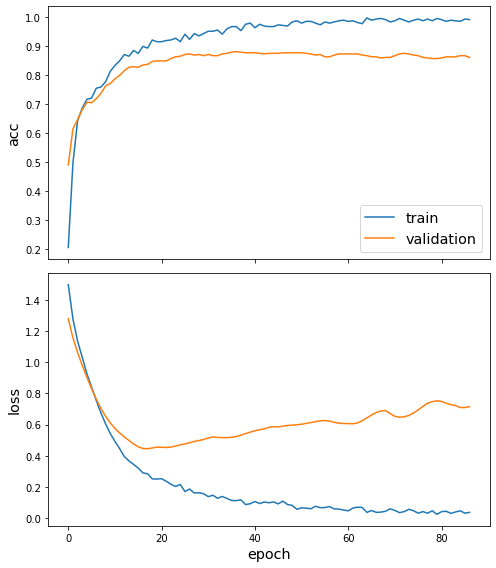

In [120]:
# show an accuracy graph
sg.utils.plot_history(result)

In [121]:
# Test the model on the testing data
test_gen = generator.flow(test_data.index, test_targets)
test_metrics = model.evaluate(test_gen)

1/1 [==============================] - 0s 101ms/step - loss: 0.5959 - acc: 0.8675
RangeIndex(start=0, stop=22470, step=1)


In [122]:
# set up the tnse by getting the full dataset
all_nodes = df_targets.index
all_gen = generator.flow(all_nodes)
all_predictions = model.predict(all_gen)

In [124]:
embedding_model = Model(inputs=x_in, outputs=x_out)
emb = embedding_model.predict(all_gen)

(1, 22470, 32)


In [125]:
X = emb.squeeze(0)

(22470, 32)

In [126]:
# turn the data into 2 dimensions.
tsne = TSNE(n_components=2)
X_2 = tsne.fit_transform(X)

/home/pentaflouride/anaconda3/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/pentaflouride/anaconda3/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[Text(0.5, 1.0, 'TSNE visualization of GCN embeddings for facebook dataset')]

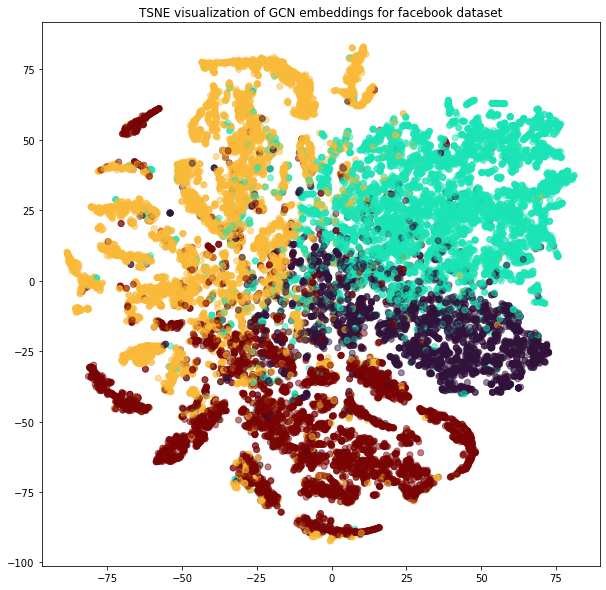

In [145]:
# do an tsne plot
fig, ax = plt.subplots(figsize=(10, 10))
ax.scatter(X_2[:, 0],X_2[:, 1],c=df_targets.squeeze(),cmap='turbo',
    alpha=0.5)
ax.set(
    title="TSNE visualization of GCN embeddings for facebook dataset"
)